In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
folder_path = '/content'
dataframes_dict = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        key = filename.split('_')[0]
        file_path = os.path.join(folder_path, filename)
        dataframes_dict[key] = pd.read_csv(file_path, sep=';')
        dataframes_dict[key]['<DATE>'] = pd.to_datetime(dataframes_dict[key]['<DATE>'], format='%y%m%d')
dataframes = list(dataframes_dict.values())

In [4]:
# Вычисление логарифмических доходностей
for i, df in enumerate(dataframes):

    df['log_return'] = np.nan

    for j in range(1, len(df)):
        prev_date = df.iloc[j - 1]['<DATE>']
        current_date = df.iloc[j]['<DATE>']

        # Проверяем, что предыдущая дата идет непосредственно перед текущей
        if (current_date - prev_date).days == 1:
            df.at[df.index[j], 'log_return'] = np.log(df.iloc[j]['<CLOSE>']) - np.log(df.iloc[j - 1]['<CLOSE>'])
        else:
            df.at[df.index[j], 'log_return'] = np.nan  # Если предыдущей даты нет, пишем NA

    df = df.dropna(subset=['log_return'])
    dataframes[i] = df

In [5]:
log_return_dfs = []

for df in dataframes:
    log_return_df = df[['<DATE>', 'log_return']].copy()

    ticker = df['<TICKER>'].iloc[0]
    log_return_df.rename(columns={'log_return': ticker}, inplace=True)

    log_return_dfs.append(log_return_df)

# Объединяем все датафреймы по колонке '<DATE>'
merged_df = log_return_dfs[0]
for df in log_return_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='<DATE>', how='inner')  # Объединяем по дате

print(merged_df.head())

      <DATE>      GAZP    EURUSD        BZ
0 2024-05-15 -0.011081  0.002027 -0.007940
1 2024-05-16  0.005174  0.006866  0.001328
2 2024-05-17  0.005781 -0.001829  0.006493
3 2024-05-18 -0.017314 -0.000028  0.006689
4 2024-05-22 -0.038589 -0.000654 -0.014197


In [6]:
merged_df.shape

(193, 4)

In [7]:
cols = ['GAZP','BZ']
stocks = merged_df[cols]

In [8]:
stocks.corr()

,GAZP,BZ
GAZP,1.00000,0.19486
BZ,0.19486,1.00000


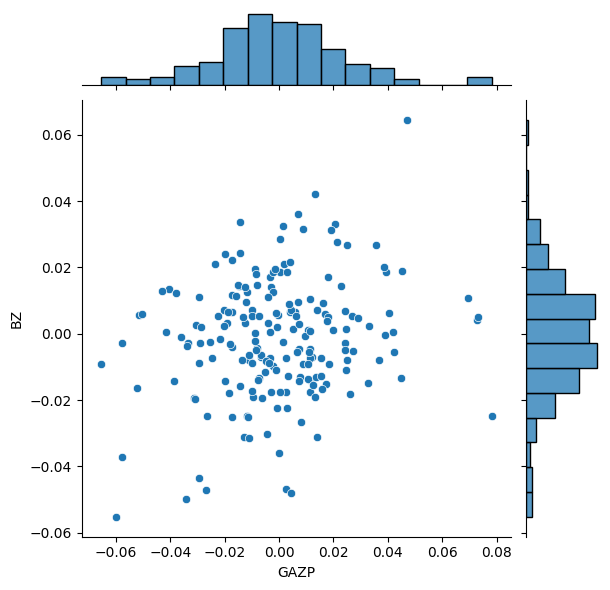

In [9]:
sns.jointplot(data=stocks, x="GAZP", y="BZ")

In [10]:
%pip install copulas

In [11]:
from copulas.visualization import scatter_2d, dist_1d,compare_2d
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import Univariate

In [12]:
copula = GaussianMultivariate()
copula.fit(stocks)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [13]:
synthetic = copula.sample(len(stocks))

In [15]:
compare_2d(stocks, synthetic)